谱门限：STFT → 估计每个频点的噪声底 → 计算信噪比门限 → 软掩蔽 → iSTFT

In [9]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pywt
import soundfile as sf
import noisereduce as nr

In [3]:
def denoise_spectral_gate(waveform, sample_rate, stationary, y_noise, n_fft, hop_length, time_mask_smooth_ms, freq_mask_smooth_hz, prop_decrease):
    """
    对输入的音频信号进行频谱门限去噪。

    参数:
    waveform (numpy.ndarray): 输入音频信号。
    sample_rate (int): 音频信号的采样率。
    n_fft (int): FFT窗口大小。
    hop (int): 帧移大小。
    win (str): 窗口类型。
    noise_quantile (float): 噪声量化值。
    reduce_db (float): 减少的分贝值。
    floor_db (float): 下限的分贝值。
    beta (float): 门限系数。

    返回:
    numpy.ndarray: 去噪后的音频信号。
    """
    # 第一版
    # S = librosa.stft(waveform, n_fft=n_fft, hop_length=hop, window=win)
    # mag, phase = np.abs(S), np.angle(S)

    # noise = np.quantile(mag, noise_quantile, axis=1, keepdims=True)
    # snr_db = 20 * np.log10((mag + 1e-10) / (noise + 1e-10))
    # mask = np.clip((snr_db + reduce_db) / (reduce_db + floor_db), 0.0, 1.0)
    # mask = beta * mask + (1-beta) * np.minimum.accumulate(mask, axis=1)

    # S_denoised = (mag * mask) * np.exp(1j * np.angle(S))
    # S_denoised  = librosa.istft(S_denoised, hop_length=hop, window=win, center=True, length=len(waveform))
    # return S_denoised
 
    denoised_waveform = nr.reduce_noise(waveform, sample_rate, stationary=stationary, y_noise=y_noise, n_fft=n_fft, hop_length=hop_length, time_mask_smooth_ms=time_mask_smooth_ms, freq_mask_smooth_hz=freq_mask_smooth_hz, prop_decrease=prop_decrease)
    return denoised_waveform


In [4]:
def process_folder(input_folder, output_folder):
    # 确保输出文件夹存在，没有的话自动创建
    os.makedirs(output_folder, exist_ok=True)
    # 处理输入文件夹中的所有 WAV 文件
    for file in os.listdir(input_folder):
        if file.endswith(".wav"):
            input_file_path = os.path.join(input_folder, file)
            output_file_path = os.path.join(output_folder, file)

            waveform, sample_rate = librosa.load(input_file_path, sr=None)
            y_noise = waveform[:int(0.5 * sample_rate)]
            
            # 执行去噪函数
            denoised_waveform = denoised_signal = denoise_spectral_gate(
                    waveform, 
                    sample_rate, 
                    stationary=True, 
                    y_noise=y_noise,
                    n_fft=4096, 
                    hop_length=512, 
                    time_mask_smooth_ms=80, 
                    freq_mask_smooth_hz=400, 
                    prop_decrease=0.8, 
                )
            # 保存去噪后的音频
            sf.write(output_file_path, denoised_waveform, sample_rate)
            print(f"{file} processed and saved.")
        else:
            print(f"{file} is not a WAV file.")
    print("All files processed.")

In [5]:
def plot_waveform(waveform, sample_rate, title='Waveform'):
    """
    绘制音频波形。

    参数:
    waveform (numpy.ndarray): 音频信号，形状为 (n_samples,)。
    sample_rate (int): 音频采样率，单位为 Hz。
    title (str, optional): 图表标题，默认值为 'Waveform'。
    """
    # 计算时间轴
    time_scale = np.linspace(0, len(waveform) / sample_rate, len(waveform))

    # 绘制波形
    plt.figure(figsize=(12, 8))
    plt.plot(time_scale, waveform)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()

In [6]:
audio_file = r"E:\数据集\ShipEar\shipsEar_AUDIOS\16__10_07_13_mscOpera_InicioSalida.wav"
waveform, sample_rate = librosa.load(audio_file, sr=None)

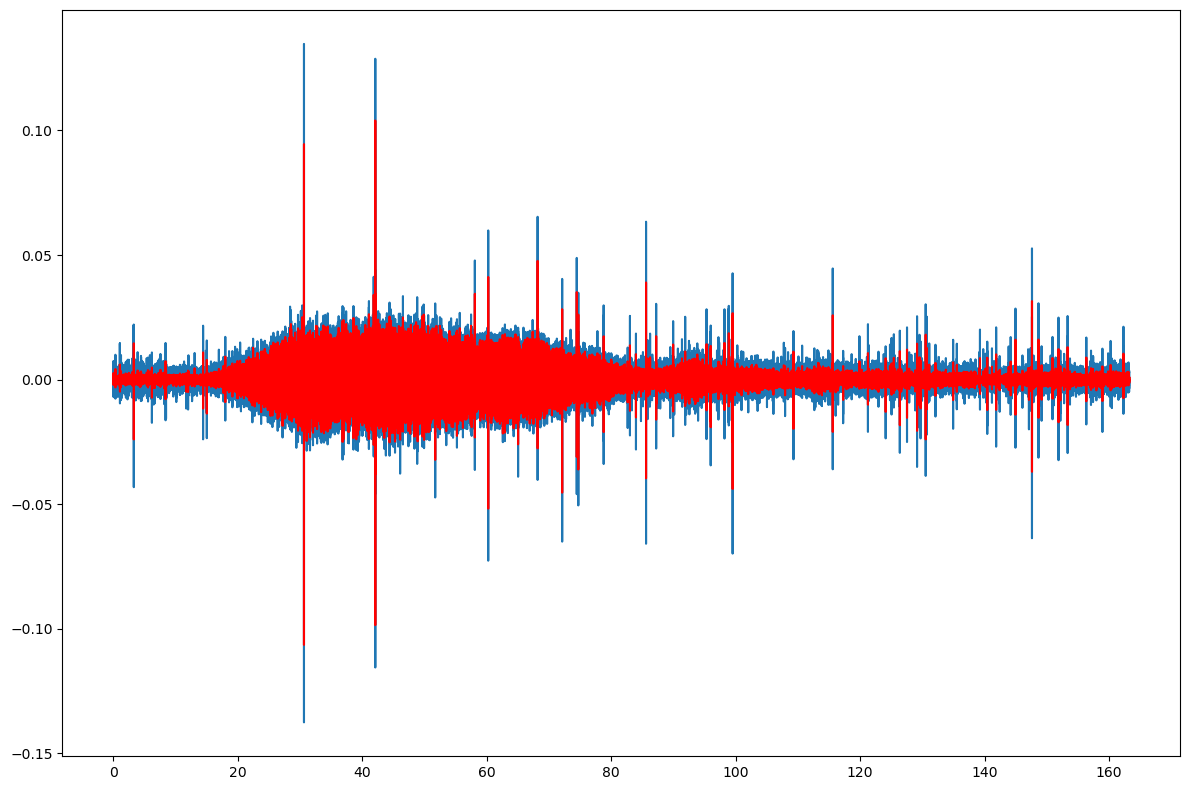

In [7]:
y_noise = waveform[:int(0.5 * sample_rate)]

denoised_signal = denoise_spectral_gate(
                    waveform, 
                    sample_rate, 
                    stationary=True, 
                    y_noise=y_noise,
                    n_fft=4096, 
                    hop_length=512, 
                    time_mask_smooth_ms=80, 
                    freq_mask_smooth_hz=400, 
                    prop_decrease=0.8, 
                )

t = np.arange(len(waveform)) / sample_rate
plt.figure(figsize=(12, 8))
plt.plot(t, waveform)
plt.plot(t, denoised_signal, c='r')
plt.tight_layout()
plt.show()

In [8]:
def seg_energy(x, sr, t0, t1):
    i0, i1 = int(t0 * sr), int(t1 * sr)
    return (x[i0 : i1] ** 2).mean()

e0 = seg_energy(waveform, sample_rate, 0, 0.5)

e1 = seg_energy(denoised_signal, sample_rate, 0.0, 0.5)
print(f"Noise reduction: {10 * np.log10(e0/e1):.1f} dB")

Noise reduction: 12.4 dB


In [76]:
# 替换为输入和输出文件夹路径
input_folder = r"E:\数据集\ShipEar\shipsEar_AUDIOS"
output_folder = r"E:\数据集\ShipEar\data_preprocessing\1_audio_noise_reduction"

In [78]:
# 处理整个文件夹中的所有文件
process_folder(input_folder, output_folder)

.DS_Store is not a WAV file.
10__10_07_13_marDeOnza_Sale.wav processed and saved.
11__10_07_13_minhoUno_Entra.wav processed and saved.
12__10_07_13_minhoUno_Sale.wav processed and saved.
13__10_07_13_piraCies_Entra.wav processed and saved.
14__10_07_13_piraCies_Espera.wav processed and saved.
15__10_07_13_radaUno_Pasa.wav processed and saved.
16__10_07_13_mscOpera_InicioSalida.wav processed and saved.
17__10_07_13_visionSub_Entra.wav processed and saved.
18__18_07_13_AutoPrideEntra.wav processed and saved.
19__18_07_13_AutoprideMarchaAtras.wav processed and saved.
20__18_07_13_AutopridePrepManiobra.wav processed and saved.
21__18_07_13_lanchaMotora.wav processed and saved.
22__19_07_13_adventure_maniobra.wav processed and saved.
23__19_07_13_adventure_parado.wav processed and saved.
24__19_07_13_adventureFrenando_duda.wav processed and saved.
25__19_07_13_adventureOfTheSea_llegando.wav processed and saved.
26__19_07_13_Lancha.wav processed and saved.
27__19_07_13_Lancha2.wav processed 